In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from src.model.reconstruction import MemAutoEncoder, DAGMM
from src.model.one_class import DeepSVDD
from src.trainer.ids import MemAEIDSTrainer, DAGMMIDSTrainer, DeepSVDDIDSTrainer
from src.datamanager.dataset import IDS2018Dataset
from src.utils import metrics
from src.utils.utils import ids_misclf_per_label


In [2]:
# Setup base folder structure
dataset_path = "../../data/IDS2018/ids2018.csv"
base_path = "ids2018/thresh-optim"

# General arguments
batch_size = 1024
device = "cuda"
act_fn = "relu"
n_layers = 4
compression_factor = 2
lr = 1e-4
n_epochs = 200
thresh_mode = "auto"

print("arguments set")

arguments set


In [25]:
def misclf_barplot(
        df,
        fname
):
    sns.set_theme(style="whitegrid")

    # Initialize the matplotlib figure
    f, axs = plt.subplots(figsize=(8, 7), ncols=2)

    # Plot misclassification rates
    sns.set_color_codes("pastel")
    sns.barplot(
        x=df["Misclassified ratio"] * 100,
        y=df.index,
        data=df,
        label="Misclassification ratio",
        color="b",
        ax=axs[0]
    )

    # Plot correct classification rate
    sns.set_color_codes("muted")
    sns.barplot(
        x=(1-df["Misclassified ratio"]) * 100,
        y=df.index,
        data=df,
        label="Correctly classified ratio",
        color="b",
        ax=axs[1]
    )

    # Add a legend and informative axis label
    for ax in axs:
        ax.legend(ncol=2, loc="lower right", frameon=True)
        ax.set(xlim=(0, 100), ylabel="", xlabel="Classification rate per attack category")
    sns.despine(left=True, bottom=True)
    f.savefig("{}.png".format(fname))
    f.savefig("{}.pdf".format(fname))

## Load data

In [31]:
dataset = IDS2018Dataset(path=dataset_path, pct=0.5, seed=42)
columns = dataset.columns[:-2]
partial_anomaly_labels = np.unique(dataset.labels)
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
print("data loaded with shape {}".format(dataset.shape()))

# Use Arrhythmia for testing before launching a training session on the much larger IDS2018 dataset
# from src.datamanager.dataset import ArrhythmiaDataset
# dataset = ArrhythmiaDataset(path="C:\\Users\\verdi\\Documents\\Datasets\\Arrhythmia\\3_minified\\arrhythmia_normalized.npz")
# batch_size = 8
# train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
# print("data loaded with shape {}".format(dataset.shape()))

data loaded with shape (9490582, 66)


In [32]:
labels = set()
for sample in test_ldr:
    X, y, label = sample
    for l in label:
        labels.add(l)
labels

{'Benign', 'Bot', 'DDoS', 'DoS', 'Web Attack'}

## DeepSVDD Testing

In [5]:
# Setup model and trainer
dsvdd_model = DeepSVDD(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_layers=n_layers,
    compression_factor=compression_factor,
    act_fn=act_fn,
)
dsvdd_trainer = DeepSVDDIDSTrainer(
    validation_ldr=test_ldr,
    model=dsvdd_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    device=device,
    run_test_validation=False,
    keep_ckpt=False,
)

In [7]:
best_epoch = 25 * 5 + 1
dsvdd_best_fname = os.path.abspath(base_path + "/deepsvdd/checkpoint/deepsvdd_epoch={}.pt".format(best_epoch))
dsvdd_trainer, dsvdd_model = DeepSVDDIDSTrainer.load_from_file(dsvdd_best_fname, dsvdd_trainer, dsvdd_model)
y_test_true, test_scores, test_labels = dsvdd_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
results

{'Precision': 0.7893798113478714,
 'Recall': 0.7014978704513988,
 'F1-Score': 0.7428486768539803,
 'AUPR': 0.7802524599563221,
 'AUROC': 0.7396393809086422,
 'Thresh_star': 4.334627101698629e-11,
 'Quantile_star': 60.08985509709436}

In [8]:
# Misclassified instances per label
deepsvdd_misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
deepsvdd_misclf_df = deepsvdd_misclf_df.sort_values("Misclassified ratio", ascending=False)
deepsvdd_misclf_df.to_csv(base_path + "/deepsvdd/deepsvdd_misclassifications.csv")
deepsvdd_misclf_df

,# Instances test set,Misclassified count,Misclassified ratio
Web Attack,566,283,0.500000
Bot,286191,114442,0.399880
Benign,4943560,1085802,0.219640
DDoS,287289,43660,0.151972
DoS,601802,90559,0.150480


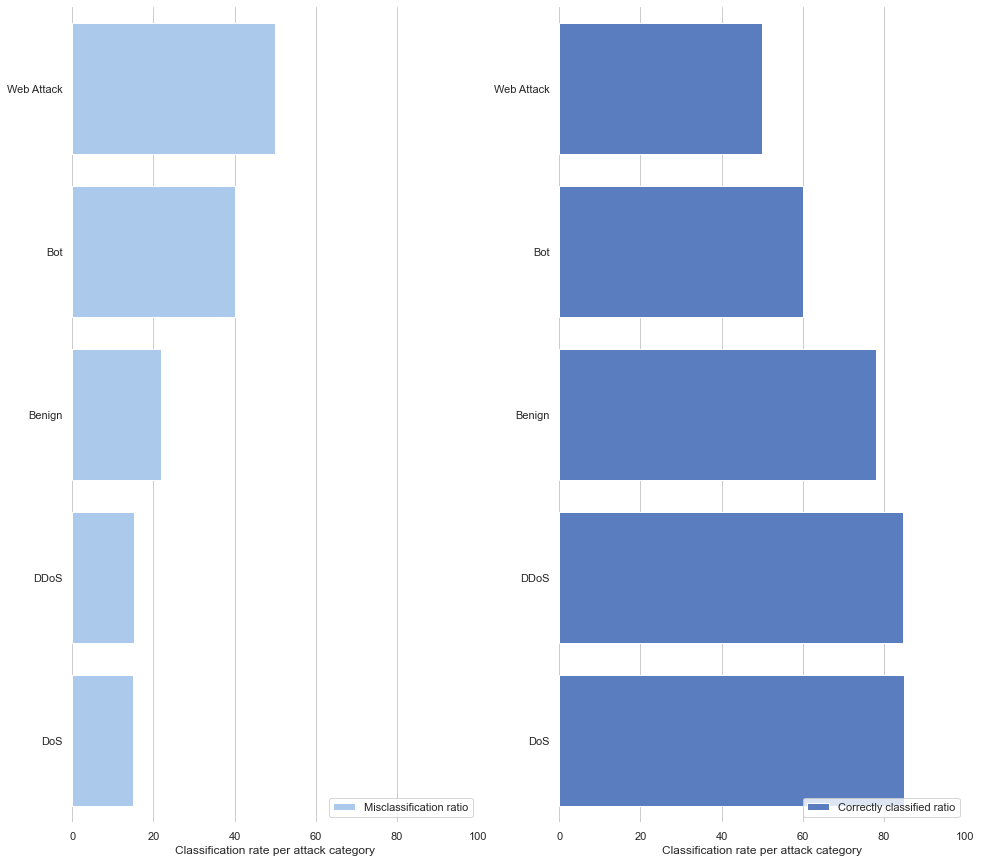

In [14]:
misclf_barplot(deepsvdd_misclf_df, base_path + "/deepsvdd/deepsvdd_classifiation_rates")

In [ ]:
# Save memory
del dsvdd_trainer
del dsvdd_model

## DAGMM Testing

In [22]:
# Set DAGMM-specific hyperparameters
n_mixtures = 4
latent_dim = 1
lambda_1 = 0.005
lambda_2 = 0.1
reg_covar=1e-6

# Setup model and trainers
dagmm_model = DAGMM(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_mixtures=n_mixtures,
    latent_dim=latent_dim,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    reg_covar=reg_covar,
    n_layers=n_layers,
    compression_factor=compression_factor,
    ae_act_fn="relu",
    gmm_act_fn="relu"
)
dagmm_trainer = DAGMMIDSTrainer(
    validation_ldr=test_ldr,
    device=device,
    model=dagmm_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    run_test_validation=False,
    keep_ckpt=False,
    thresh_mode=thresh_mode
)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
best_epoch = 1 * 5 + 1
dagmm_best = base_path + "dagmm/checkpoint/dagmm_epoch={}.pt".format(best_epoch)
dagmm_trainer, dagmm_model = DAGMMIDSTrainer.load_from_file(dagmm_best, dagmm_trainer, dagmm_model)
dagmm_trainer.n_epochs = best_epoch
y_test_true, test_scores, test_labels = dagmm_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
results

In [ ]:
dagmm_misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
dagmm_misclf_df = dagmm_misclf_df.sort_values("Misclassified ratio", ascending=False)
dagmm_misclf_df.to_csv(base_path + "/dagmm/dagmm_misclassifications.csv")
dagmm_misclf_df

In [ ]:
misclf_barplot(dagmm_misclf_df, base_path + "/dagmm/dagmm_classification_rates")

In [ ]:
# Save memory
del dagmm_model
del dagmm_trainer

## MemAE training

In [ ]:
# Set MemAE-specific hyperparameters
latent_dim = 1
mem_dim = 50
shrink_thres = 0.0025
n_layers = 4
compression_factor = 2
act_fn = "relu"
alpha = 2e-4

# Setup model and trainers
memae_model = MemAutoEncoder(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    mem_dim=mem_dim,
    latent_dim=latent_dim,
    shrink_thres=shrink_thres,
    n_layers=n_layers,
    compression_factor=2,
    alpha=2e-4,
    act_fn="relu",
)
memae_trainer = MemAEIDSTrainer(
    validation_ldr=test_ldr,
    device=device,
    model=memae_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    run_test_validation=False,
    keep_ckpt=False,
)

In [ ]:
best_epoch = 38 * 5 + 1
best = base_path + "/memae/checkpoint/memae_epoch={}.pt".format(best_epoch)
trainer, model = MemAEIDSTrainer.load_from_file(best, memae_trainer, memae_model)
trainer.n_epochs = best_epoch
y_test_true, test_scores, test_labels = trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
results

In [ ]:
memae_misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
memae_misclf_df = memae_misclf_df.sort_values("Misclassified ratio", ascending=False)
memae_misclf_df.to_csv(base_path + "/memae/memae_misclassifications.csv")
memae_misclf_df

In [ ]:
misclf_barplot(memae_misclf_df, base_path + "/memae/memae_classifiation_rates")

In [ ]:
del memae_model
del memae_trainer